# Step 0 — Specify config  and build TensorRT engines

Before running CAICE inference, please **choose a component-level precision** and **build TensorRT engines** from your FP32 ONNX.
### 1) Specify component precision 

Use the format:

* `ga-fp8`, `ga-fp16`
* `gs-fp8`, `gs-fp16`
* `ha-fp8`, `ha-fp16`
* `hs-fp8`, `hs-fp16`

default configs:

* `ga-fp8,gs-fp16,ha-fp8(if exist),hs-fp8(if exist)`

> Note: For FP8, the build script will quantize the corresponding sub-ONNX (Q/DQ) and then build a **strongly-typed** TensorRT engine.

### 2) Define component boundaries (`config.json`)

After choosing the precision, you must define **graph boundaries** for each component in `boundaries.config`.
The build script uses these boundaries to **extract sub-graphs** (g_a / g_s / h_a / h_s) from the full FP32 ONNX before quantizing and building engines.

### What to provide for each component

For every component, specify:

* `inputs`: a list of **input tensor names** in the ONNX graph
* `outputs`: a list of **output tensor names** in the ONNX graph

Example (JSON):

```json
{
  "ga": { "inputs": ["input"], "outputs": ["/g_a/g_a.6/Conv_output_0"] },
  "ha": { "inputs": ["/g_a/g_a.6/Conv_output_0"], "outputs": ["<ha_out_tensor>"] },
  "hs": { "inputs": ["<hs_in_tensor>"], "outputs": ["/entropy_bottleneck/Transpose_1_output_0"] },
  "gs": { "inputs": ["/entropy_bottleneck/Transpose_1_output_0"], "outputs": ["output"] }
}
```

### Tips

* Tensor names must match **exactly** what appears in the exported ONNX (case-sensitive).
* You can inspect tensor names using **Netron** or by printing ONNX graph I/O names in Python.
* If you only plan to accelerate a subset of components, you can still define all boundaries now and only build engines for the components listed in your precision config.


### 3) Prepare calibration data and input shapes

For **FP8 components**, calibration data is required to determine quantization scales.

You must also specify the **exact input shape** used to build engines, since TensorRT engines are shape-specific.


In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # 定位卡点，确认后可去掉

import torch
from compressai.zoo import bmshj2018_hyperprior, mbt2018_mean

quality = 1
project_dir = "/hwj"
device = "cuda:0"
model_name = "mbt2018-mean"

# load model (CPU -> GPU)
model = mbt2018_mean(quality=quality, pretrained=False)
state = torch.load(f"{project_dir}/data/model/{model_name}-{quality}.pth", map_location="cpu")
model.load_state_dict(state)
model = model.to(device).eval()

print("Load model done.")

class Wrap(torch.nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m

    # # bmshj2018_hyperprior
    # def forward(self, x):
    #     y = self.m.g_a(x)
    #     z = self.m.h_a(torch.abs(y))
    #     z_hat, _ = self.m.entropy_bottleneck(z)
    #     scales_hat = self.m.h_s(z_hat)
    #     y_hat, _ = self.m.gaussian_conditional(y, scales_hat)
    #     x_hat = self.m.g_s(y_hat)
    #     return x_hat, scales_hat
    # mbt2018_mean
    def forward(self, x):
        y = self.m.g_a(x)
        z = self.m.h_a(y)
        z_hat, _ = self.m.entropy_bottleneck(z)
        gaussian_params = self.m.h_s(z_hat)
        scales_hat, means_hat = gaussian_params.chunk(2, 1)
        y_hat, _ = self.m.gaussian_conditional(y, scales_hat, means=means_hat)
        x_hat = self.m.g_s(y_hat)
        return x_hat, scales_hat

wrapped = Wrap(model).eval()

dummy_input = torch.randn((512, 3, 128, 128), device=device, dtype=torch.float32)
print("Input data prepared.")

# 先确认 forward 是否真的能跑完
with torch.no_grad():
    print("Running warmup forward...")
    _ = wrapped(dummy_input)
    torch.cuda.synchronize()
print("Warmup done.")

onnx_path = f"{project_dir}/data/model/onnx/{model_name}-{quality}-f32.onnx"
print("Exporting to ONNX...")

with torch.no_grad():
    torch.onnx.export(
        wrapped,
        dummy_input,
        onnx_path,
        input_names=["input"],
        output_names=["x_hat", "scales_hat"],
        opset_version=17,
        # do_constant_folding=False,
    )
    
model = model.eval().to(device).to(torch.float16)
dummy_input = torch.randn((512, 3, 128, 128), device=device, dtype=torch.float16)
onnx_path = f"{project_dir}/data/model/onnx/{model_name}-{quality}-f16.onnx"
wrapped = Wrap(model).eval()

with torch.no_grad():
    torch.onnx.export(
        wrapped,
        dummy_input,
        onnx_path,
        input_names=["input"],
        output_names=["x_hat", "scales_hat"],
        opset_version=17,
        # do_constant_folding=False,
    )

print("Export done:", onnx_path)




In [ ]:
!python ./utils/build_engines.py \
--onnx_fp32 /hwj/data/model/onnx/mbt2018-mean-1-f32.onnx \
--onnx_fp16 /hwj/data/model/onnx/mbt2018-mean-1-f16.onnx \
--input_shape 512,3,128,128 \
--config ga-fp16,gs-fp16,ha-fp16,hs-fp16 \
--boundaries /hwj/project/CompressAI-Science/examples/config-mbt2018-mean-q1.json \
--calib_npy /hwj/project/aiz-accelerate/data/nyx-dark_matter_density.npy \
--out_dir /hwj/project/CompressAI-Science/examples/out_engines \
--model_tag mbt2018-mean-q1 \
--max_calib_samples 512 \
--prefer_cuda_ort

# Step 1 — Run Benchmark

mbt2018-mean

In [ ]:
import numpy as np
import torch
from compressai.zoo import bmshj2018_factorized, bmshj2018_hyperprior, mbt2018_mean
from compressai.runtime import build_runtime
from compressai.runtime.config import RuntimeConfig
from compressai.runtime.codecs import GpuPackedEntropyCodec
from compressai.runtime.utils.benchmark import run_e2e

device = "cuda:0"

# 1) load net
net = mbt2018_mean(quality=1, pretrained=False).to(device).eval()
state = torch.load("/hwj/data/model/mbt2018-mean-1.pth", map_location=device)
net.load_state_dict(state)

# 2) codec (in runtime)
codec = GpuPackedEntropyCodec(
    net.entropy_bottleneck,
    gaussian_conditional=net.gaussian_conditional,
    P=12
)

# 3) runtime (TRT, dtype auto-infer)
cfg = RuntimeConfig(
    model_name="mbt2018_mean",
    ga_input_dtype=torch.float16,
    gs_input_dtype=torch.float16,
    ha_input_dtype=torch.float16,
    hs_input_dtype=torch.float16,
    codec_input_dtype=torch.float32,
    trt_engines={
        "ga": "/hwj/project/CompressAI-Science/examples/out_engines/engines/mbt2018-mean-q1/ga/fp16.engine",
        "gs": "/hwj/project/CompressAI-Science/examples/out_engines/engines/mbt2018-mean-q1/gs/fp16.engine",
        "ha": "/hwj/project/CompressAI-Science/examples/out_engines/engines/mbt2018-mean-q1/ha/fp16.engine",
        "hs": "/hwj/project/CompressAI-Science/examples/out_engines/engines/mbt2018-mean-q1/hs/fp16.engine",
    },
)
engine = build_runtime(net, codec, cfg)

# 4) data
arr = np.load("/hwj/project/aiz-accelerate/data/nyx-dark_matter_density.npy")
x = torch.from_numpy(arr).float().to(device)

# 5) benchmark (auto stream)
stats, x_hat, x = run_e2e(engine, codec, x, warmup=5, iters=10)
stats


### TCM

Load Model

In [ ]:
import numpy as np
import torch
from compressai.models import TCM

device = "cuda:0"

# 1) load net
net = TCM(config=[2,2,2,2,2,2], head_dim=[8, 16, 32, 32, 16, 8], drop_path_rate=0.0, N=64, M=320)
net = net.to(device)
net.eval()
dictory = {}

checkpoint = torch.load("/hwj/data/model/tcm-1.pth", map_location=device)
for k, v in checkpoint["state_dict"].items():
    dictory[k.replace("module.", "")] = v
net.load_state_dict(dictory)

# x = torch.randn((64, 3, 256, 256), device=device, dtype=torch.float32)

# net.update()
# y = net.compress(x)
# size = y["shape"]
# x_hat = net.decompress(y["strings"],size)
net

To ONNX

In [3]:
import os
import json
from typing import Dict, Callable, Any

import numpy as np
import torch
import torch.nn as nn

# -----------------------------
# helpers
# -----------------------------
def ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)

def to_numpy(x: torch.Tensor) -> np.ndarray:
    return x.detach().contiguous().cpu().numpy()

class CaptureInputs:
    """
    Register forward_pre_hook on target modules and save the FIRST tensor input.
    """
    def __init__(self):
        self.captured: Dict[str, torch.Tensor] = {}
        self.handles = []

    def add(self, name: str, module: nn.Module):
        def _hook(mod, inputs):
            # inputs is a tuple; we take the first Tensor
            if name in self.captured:
                return
            for item in inputs:
                if torch.is_tensor(item):
                    self.captured[name] = item.detach()
                    break
        h = module.register_forward_pre_hook(_hook)
        self.handles.append(h)

    def close(self):
        for h in self.handles:
            h.remove()
        self.handles.clear()

# -----------------------------
# build component registry
# -----------------------------
def build_tcm_components(model) -> Dict[str, nn.Module]:
    """
    Map engine runner keys -> torch submodules to export.
    Adjust names to match your engine's runners.
    """
    comps: Dict[str, nn.Module] = {}

    comps["ga"] = model.g_a
    comps["ha"] = model.h_a
    comps["h_scale_s"] = model.h_scale_s
    comps["h_mean_s"]  = model.h_mean_s
    comps["gs"] = model.g_s

    # per-slice modules
    for i in range(model.num_slices):
        comps[f"atten_mean_{i}"]  = model.atten_mean[i]
        comps[f"atten_scale_{i}"] = model.atten_scale[i]
        comps[f"cc_mean_{i}"]     = model.cc_mean_transforms[i]
        comps[f"cc_scale_{i}"]    = model.cc_scale_transforms[i]
        comps[f"lrp_transforms_{i}"] = model.lrp_transforms[i]
    return comps

# -----------------------------
# export one module to onnx
# -----------------------------
@torch.no_grad()
def export_module_onnx(module: nn.Module, example_input: torch.Tensor, out_path: str, opset: int = 17):
    module.eval()
    ensure_dir(os.path.dirname(out_path))
    torch.onnx.export(
        module,
        example_input,
        out_path,
        input_names=["input"],
        output_names=["output"],
        opset_version=opset,
    )

# -----------------------------
# main workflow
# -----------------------------
@torch.no_grad()
def main():
    # -------- config --------
    device = "cuda:0"
    input_shape = (512, 3, 128, 128)   # your calib batch
    model_path = "/hwj/data/model/tcm-1.pth"  # your model path
    out_root = "/hwj/project/CompressAI-Science/examples/out_engines"  # change to yours
    out_onnx_fp32 = os.path.join(out_root, "subonnx/tcm-q1")
    out_onnx_fp16 = os.path.join(out_root, "subonnx/tcm-q1")
    out_calib = os.path.join(out_root, "calib/tcm-q1")
    out_meta = os.path.join(out_root, "components_meta/tcm-q1.json")

    ensure_dir(out_onnx_fp32)
    ensure_dir(out_onnx_fp16)
    ensure_dir(out_calib)

    # -------- load model --------
    # TODO: replace with your exact load code
    from compressai.models import TCM
    model = TCM(config=[2,2,2,2,2,2], head_dim=[8, 16, 32, 32, 16, 8], N=64, M=320)
    # load weights...
    dictory = {}

    checkpoint = torch.load(model_path, map_location=device)
    for k, v in checkpoint["state_dict"].items():
        dictory[k.replace("module.", "")] = v
    model.load_state_dict(dictory)
    model = model.to(device).eval()

    # -------- discover components from pytorch modules --------
    comps = build_tcm_components(model)

    # -------- capture real inputs by running full forward once --------
    cap = CaptureInputs()
    for name, mod in comps.items():
        cap.add(name, mod)

    bin_path = "/hwj/data/sdrbench/nyx/512x512x512/bin/dark_matter_density.f32"
    shape = (512, 512, 512)

    arr = np.fromfile(bin_path, dtype=np.float32)   # fp32
    arr = arr.reshape(shape)

    x = torch.from_numpy(arr).to("cuda:0")  # or device
    x = x[:64 * 3, 100:356, 100:356]
    x = x.reshape(64, 3, 256, 256)
    out_path = "/hwj/project/aiz-accelerate/data/dark_matter_density_64x3x256x256.npy"
    np.save(out_path, x.detach().cpu().numpy())

    print("Saved:", out_path)
    # run ONE forward to feed the graph
    _ = model(x)   # if your model forward returns dict, it's ok

    cap.close()

    # -------- export + save calib --------
    meta = {
        "model_input_shape": list(input_shape),
        "components": {}
    }

    for name, mod in comps.items():
        if name not in cap.captured:
            print(f"[Skip] no captured input for component: {name}")
            continue

        inp_fp32 = cap.captured[name]
        # save input npy (fp32) for calibration & shape
        calib_path = os.path.join(out_calib, f"{name}.npy".replace("/", "_"))
        np.save(calib_path, to_numpy(inp_fp32.float()))

        # export fp32
        onnx_fp32_path = os.path.join(out_onnx_fp32, f"{name}_fp32.onnx".replace("/", "_"))
        export_module_onnx(mod.float(), inp_fp32.float(), onnx_fp32_path)

        # export fp16
        inp_fp16 = inp_fp32.half()
        onnx_fp16_path = os.path.join(out_onnx_fp16, f"{name}_fp16.onnx".replace("/", "_"))
        export_module_onnx(mod.half(), inp_fp16, onnx_fp16_path)

        meta["components"][name] = {
            "calib_npy": calib_path,
            "input_shape": list(inp_fp32.shape),
            "onnx_fp32": onnx_fp32_path,
            "onnx_fp16": onnx_fp16_path,
        }
        print(f"[OK] {name}: in={tuple(inp_fp32.shape)}")

    with open(out_meta, "w", encoding="utf-8") as f:
        json.dump(meta, f, indent=2, ensure_ascii=False)

    print("\nDone. Meta saved to:", out_meta)

if __name__ == "__main__":
    main()


Saved: /hwj/project/aiz-accelerate/data/dark_matter_density_64x3x256x256.npy


/tmp/ipykernel_184843/211225734.py:75: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


[OK] ga: in=(64, 3, 256, 256)
[OK] ha: in=(64, 320, 16, 16)
[OK] h_scale_s: in=(64, 192, 4, 4)
[OK] h_mean_s: in=(64, 192, 4, 4)
[OK] gs: in=(64, 320, 16, 16)
[OK] atten_mean_0: in=(64, 320, 16, 16)
[OK] atten_scale_0: in=(64, 320, 16, 16)
[OK] cc_mean_0: in=(64, 320, 16, 16)
[OK] cc_scale_0: in=(64, 320, 16, 16)
[OK] lrp_transforms_0: in=(64, 384, 16, 16)
[OK] atten_mean_1: in=(64, 384, 16, 16)
[OK] atten_scale_1: in=(64, 384, 16, 16)
[OK] cc_mean_1: in=(64, 384, 16, 16)
[OK] cc_scale_1: in=(64, 384, 16, 16)
[OK] lrp_transforms_1: in=(64, 448, 16, 16)
[OK] atten_mean_2: in=(64, 448, 16, 16)
[OK] atten_scale_2: in=(64, 448, 16, 16)
[OK] cc_mean_2: in=(64, 448, 16, 16)
[OK] cc_scale_2: in=(64, 448, 16, 16)
[OK] lrp_transforms_2: in=(64, 512, 16, 16)
[OK] atten_mean_3: in=(64, 512, 16, 16)
[OK] atten_scale_3: in=(64, 512, 16, 16)
[OK] cc_mean_3: in=(64, 512, 16, 16)
[OK] cc_scale_3: in=(64, 512, 16, 16)
[OK] lrp_transforms_3: in=(64, 576, 16, 16)
[OK] atten_mean_4: in=(64, 576, 16, 16)
[

To engine

In [ ]:
import os
import subprocess
from typing import List, Optional

import numpy as np


# -----------------------------
# utils
# -----------------------------
def ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)

def run_cmd(cmd: List[str]):
    print(" ".join(cmd), flush=True)
    subprocess.run(cmd, check=True)

def safe_name(comp: str) -> str:
    # filenames use underscore, keep consistent
    return comp.replace("/", "_").replace(".", "_")

def list_components(subonnx_dir: str) -> List[str]:
    """
    Discover components by scanning *_fp32.onnx in subonnx_dir.
    Component base name: "<comp>_fp32.onnx" -> "<comp>"
    """
    comps = set()
    for fn in os.listdir(subonnx_dir):
        if fn.endswith("_fp32.onnx"):
            comps.add(fn[:-len("_fp32.onnx")])
    return sorted(comps)

def modelopt_quant_fp8(fp32_onnx: str, out_fp8_qdq_onnx: str, calib_npy: str):
    if not calib_npy:
        raise ValueError("FP8 quant requires calib_npy")
    run_cmd([
        "python", "-m", "modelopt.onnx.quantization",
        f"--onnx={fp32_onnx}",
        "--quantize_mode=fp8",
        f"--calibration_data={calib_npy}",
        "--calibration_method=max",
        f"--output_path={out_fp8_qdq_onnx}",
    ])

def build_trt_engine(onnx_path: str, engine_path: str, precision: str):
    ensure_dir(os.path.dirname(engine_path))
    cmd = ["trtexec", f"--onnx={onnx_path}", f"--saveEngine={engine_path}"]

    if precision == "fp16":
        cmd += ["--fp16"]
    elif precision == "fp8":
        cmd += ["--stronglyTyped"]
    else:
        raise ValueError(precision)

    run_cmd(cmd)


# -----------------------------
# main (call this in your code)
# -----------------------------
def build_all_component_engines(
    *,
    model_tag: str,                 # e.g. "tcm-q1"
    subonnx_root: str,              # e.g. "/hwj/out_engines/subonnx"
    calib_root: str,                # e.g. "/hwj/out_engines/calib"
    engine_root: str,               # e.g. "/hwj/out_engines/engines"
    build_fp16: bool = True,
    build_fp8: bool = True,
    reuse_qdq: bool = True,
    skip_missing_calib_for_fp8: bool = False,
):
    """
    For every component under subonnx/<model_tag>:
      - fp16: build from <comp>_fp16.onnx -> engines/<model_tag>/<comp>/fp16.engine
      - fp8 : quantize <comp>_fp32.onnx using calib/<model_tag>/<comp>.npy -> <comp>_fp8_qdq.onnx
              then build -> engines/<model_tag>/<comp>/fp8.engine

    Notes:
      - trtexec shape is NOT specified (as you requested).
      - calib file name is assumed to be <comp>.npy under calib/<model_tag>.
    """
    subonnx_dir = os.path.join(subonnx_root, model_tag)
    calib_dir   = os.path.join(calib_root, model_tag)
    engine_dir  = os.path.join(engine_root, model_tag)

    if not os.path.isdir(subonnx_dir):
        raise FileNotFoundError(f"subonnx_dir not found: {subonnx_dir}")

    comps = list_components(subonnx_dir)
    if not comps:
        raise RuntimeError(f"No *_fp32.onnx found under: {subonnx_dir}")

    print(f"[Info] Found {len(comps)} components in: {subonnx_dir}")

    for comp in comps:
        fp32_onnx = os.path.join(subonnx_dir, f"{comp}_fp32.onnx")
        fp16_onnx = os.path.join(subonnx_dir, f"{comp}_fp16.onnx")

        calib_npy = os.path.join(calib_dir, f"{comp}.npy")
        if not os.path.isfile(calib_npy):
            # fallback if caller passes dotted names etc.
            alt = os.path.join(calib_dir, f"{safe_name(comp)}.npy")
            if os.path.isfile(alt):
                calib_npy = alt

        # -------------------------
        # fp16
        # -------------------------
        if build_fp16:
            if not os.path.isfile(fp16_onnx):
                print(f"[Skip][FP16] {comp}: missing {fp16_onnx}")
            else:
                out_engine = os.path.join(engine_dir, comp, "fp16.engine")
                if os.path.isfile(out_engine):
                    print(f"[Reuse][FP16] {out_engine}")
                else:
                    print(f"\n[Build][FP16] {comp}")
                    build_trt_engine(fp16_onnx, out_engine, "fp16")

        # -------------------------
        # fp8
        # -------------------------
        if build_fp8:
            if not os.path.isfile(fp32_onnx):
                print(f"[Skip][FP8] {comp}: missing {fp32_onnx}")
                continue

            if not os.path.isfile(calib_npy):
                msg = f"[Missing][FP8] {comp}: calib not found: {calib_npy}"
                if skip_missing_calib_for_fp8:
                    print(msg + " (skip)")
                    continue
                raise FileNotFoundError(msg)

            # optional: sanity check calib load (helps debug early)
            _ = np.load(calib_npy)

            qdq_onnx = os.path.join(subonnx_dir, f"{comp}_fp8_qdq.onnx")
            if os.path.isfile(qdq_onnx) and reuse_qdq:
                print(f"[Reuse][FP8-QDQ] {qdq_onnx}")
            else:
                print(f"\n[Quant][FP8] {comp}")
                modelopt_quant_fp8(fp32_onnx, qdq_onnx, calib_npy)

            out_engine = os.path.join(engine_dir, comp, "fp8.engine")
            if os.path.isfile(out_engine):
                print(f"[Reuse][FP8] {out_engine}")
            else:
                print(f"[Build][FP8] {comp}")
                build_trt_engine(qdq_onnx, out_engine, "fp8")

    print("\nDone. Engines saved under:", engine_dir)


# -----------------------------
# example usage (edit paths)
# -----------------------------
build_all_component_engines(
    model_tag="tcm-q1",
    subonnx_root="/hwj/project/CompressAI-Science/examples/out_engines/subonnx",
    calib_root="/hwj/project/CompressAI-Science/examples/out_engines/calib",
    engine_root="/hwj/project/CompressAI-Science/examples/out_engines/engines",
    build_fp16=True,
    build_fp8=True,
    reuse_qdq=False,
    skip_missing_calib_for_fp8=False,
)


[Info] Found 30 components in: /hwj/project/CompressAI-Science/examples/out_engines/subonnx/tcm-q1

[Build][FP16] atten_mean_0
trtexec --onnx=/hwj/project/CompressAI-Science/examples/out_engines/subonnx/tcm-q1/atten_mean_0_fp16.onnx --saveEngine=/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/atten_mean_0/fp16.engine --fp16
&&&& RUNNING TensorRT.trtexec [TensorRT v101200] [b36] # trtexec --onnx=/hwj/project/CompressAI-Science/examples/out_engines/subonnx/tcm-q1/atten_mean_0_fp16.onnx --saveEngine=/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/atten_mean_0/fp16.engine --fp16
[01/15/2026-16:03:13] [I] === Model Options ===
[01/15/2026-16:03:13] [I] Format: ONNX
[01/15/2026-16:03:13] [I] Model: /hwj/project/CompressAI-Science/examples/out_engines/subonnx/tcm-q1/atten_mean_0_fp16.onnx
[01/15/2026-16:03:13] [I] Output:
[01/15/2026-16:03:13] [I] === Build Options ===
[01/15/2026-16:03:13] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLoca

Run

In [1]:
import numpy as np
import torch
from compressai.models import TCM
from compressai.runtime import build_runtime
from compressai.runtime.config import RuntimeConfig
from compressai.runtime.codecs import GpuPackedEntropyCodec
from compressai.runtime.utils.benchmark import run_e2e

device = "cuda:0"

# 1) load net
import numpy as np
import torch
from compressai.models import TCM

device = "cuda:0"

# 1) load net
net = TCM(config=[2,2,2,2,2,2], head_dim=[8, 16, 32, 32, 16, 8], drop_path_rate=0.0, N=64, M=320)
net = net.to(device)
net.eval()
dictory = {}

checkpoint = torch.load("/hwj/data/model/tcm-1.pth", map_location=device)
for k, v in checkpoint["state_dict"].items():
    dictory[k.replace("module.", "")] = v
net.load_state_dict(dictory)
net.update()


# 2) codec (in runtime)
codec = GpuPackedEntropyCodec(
    net.entropy_bottleneck,
    gaussian_conditional=net.gaussian_conditional,
    P=12
)

# 3) runtime (TRT, dtype auto-infer)
cfg = RuntimeConfig(
    model_name="tcm",
    ga_input_dtype=torch.float16,
    gs_input_dtype=torch.float16,
    ha_input_dtype=torch.float16,
    h_mean_s_input_dtype=torch.float16,
    h_scale_s_input_dtype=torch.float16,

    atten_mean_input_dtypes = [torch.float16, torch.float16, torch.float16, torch.float16, torch.float16] ,
    atten_scale_input_dtypes = [torch.float16, torch.float16, torch.float16, torch.float16, torch.float16],
    cc_mean_input_dtypes = [torch.float16, torch.float16, torch.float16, torch.float16, torch.float16],
    cc_scale_input_dtypes = [torch.float16, torch.float16, torch.float16, torch.float16, torch.float16],
    lrp_input_dtypes = [torch.float16, torch.float16, torch.float16, torch.float16, torch.float16],
    
    codec_input_dtype=torch.float32,
    trt_engines={
        "ga": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/ga/fp16.engine",
        "gs": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/gs/fp16.engine",
        "ha": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/ha/fp16.engine",
        "h_mean_s": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/h_mean_s/fp16.engine",
        "h_scale_s": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/h_scale_s/fp16.engine",

        "atten_mean_0": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/atten_mean_0/fp16.engine",
        "atten_scale_0": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/atten_scale_0/fp16.engine",
        "cc_mean_0": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/cc_mean_0/fp16.engine",
        "cc_scale_0": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/cc_scale_0/fp16.engine",
        "lrp_transforms_0": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/lrp_transforms_0/fp16.engine",

        "atten_mean_1": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/atten_mean_1/fp16.engine",
        "atten_scale_1": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/atten_scale_1/fp16.engine",
        "cc_mean_1": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/cc_mean_1/fp16.engine",
        "cc_scale_1": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/cc_scale_1/fp16.engine",
        "lrp_transforms_1": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/lrp_transforms_1/fp16.engine",

        "atten_mean_2": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/atten_mean_2/fp16.engine",
        "atten_scale_2": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/atten_scale_2/fp16.engine",
        "cc_mean_2": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/cc_mean_2/fp16.engine",
        "cc_scale_2": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/cc_scale_2/fp16.engine",
        "lrp_transforms_2": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/lrp_transforms_2/fp16.engine",

        "atten_mean_3": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/atten_mean_3/fp16.engine",
        "atten_scale_3": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/atten_scale_3/fp16.engine",
        "cc_mean_3": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/cc_mean_3/fp16.engine",
        "cc_scale_3": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/cc_scale_3/fp16.engine",
        "lrp_transforms_3": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/lrp_transforms_3/fp16.engine",

        "atten_mean_4": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/atten_mean_4/fp16.engine",
        "atten_scale_4": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/atten_scale_4/fp16.engine",
        "cc_mean_4": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/cc_mean_4/fp16.engine",
        "cc_scale_4": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/cc_scale_4/fp16.engine",
        "lrp_transforms_4": "/hwj/project/CompressAI-Science/examples/out_engines/engines/tcm-q1/lrp_transforms_4/fp16.engine",
        },
)
engine = build_runtime(net, codec, cfg)

# 4) data
arr = np.load("/hwj/project/CompressAI-Science/examples/out_engines/calib/tcm-q1/ga.npy")
x = torch.from_numpy(arr).float().to(device)

# 5) benchmark (auto stream)
stats, x_hat, x = run_e2e(engine, codec, x, warmup=0, iters=1)
stats


/root/miniconda3/envs/compressai-s/lib/python3.10/site-packages/timm/models/layers/__init__.py:49: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


[01/16/2026-16:51:08] [TRT] [W] Using default stream in enqueueV3() may lead to performance issues due to additional calls to cudaStreamSynchronize() by TensorRT to ensure correct synchronization. Please use non-default stream instead.
[01/16/2026-16:51:08] [TRT] [W] Using default stream in enqueueV3() may lead to performance issues due to additional calls to cudaStreamSynchronize() by TensorRT to ensure correct synchronization. Please use non-default stream instead.
[01/16/2026-16:51:08] [TRT] [W] Using default stream in enqueueV3() may lead to performance issues due to additional calls to cudaStreamSynchronize() by TensorRT to ensure correct synchronization. Please use non-default stream instead.
[01/16/2026-16:51:08] [TRT] [W] Using default stream in enqueueV3() may lead to performance issues due to additional calls to cudaStreamSynchronize() by TensorRT to ensure correct synchronization. Please use non-default stream instead.
[01/16/2026-16:51:08] [TRT] [W] Using default stream in 

{'input_bytes': 50331648.0,
 'enc_ms': 115.01074981689453,
 'dec_ms': 56.9015998840332,
 'enc_GBps': 0.4075705973104984,
 'dec_GBps': 0.823790545354302,
 'strings_bytes': 65216.0,
 'state_bytes': 136.0,
 'total_bytes': 65352.0,
 'bpp_strings': 0.1243896484375,
 'bpp_total': 0.1246490478515625,
 'cr_strings': 771.7684003925417,
 'cr_total': 770.1623209695189,
 'rmse': 14.836319923400879,
 'nrmse': 0.0020435641054064035,
 'maxe': 7259.5517578125,
 'psnr': 53.79224395751953}

### DCAE

#### Load Model

In [3]:
import re
import torch
from compressai.models import DCAE

device = "cuda:0"

# def strip_prefix(sd: dict, prefixes=("module.",)) -> dict:
#     out = {}
#     for k, v in sd.items():
#         nk = k
#         for p in prefixes:
#             if nk.startswith(p):
#                 nk = nk[len(p):]
#         out[nk] = v
#     return out

# def remap_entropy_bottleneck_keys(sd: dict) -> dict:
#     out = {}
#     for k, v in sd.items():
#         nk = k

#         # match both:
#         # entropy_bottleneck._matrix0
#         # entropy_bottleneck._bias0
#         # entropy_bottleneck._factor0
#         m = re.match(r"^(entropy_bottleneck)\._(matrix|bias|factor)(\d+)$", nk)
#         if m:
#             root, typ, idx = m.group(1), m.group(2), m.group(3)
#             if typ == "matrix":
#                 nk = f"{root}.matrices.{idx}"
#             elif typ == "bias":
#                 nk = f"{root}.biases.{idx}"
#             else:  # factor
#                 nk = f"{root}.factors.{idx}"

#         out[nk] = v
#     return out

# ckpt = torch.load("/hwj/data/model/dcae-1.pth", map_location="cpu")
# state_dict = ckpt["state_dict"] if "state_dict" in ckpt else ckpt

# state_dict = strip_prefix(state_dict, prefixes=("module.",))
# state_dict = remap_entropy_bottleneck_keys(state_dict)

# net = DCAE().to(device).eval()
# net.load_state_dict(state_dict, strict=False)
# net

# torch.save(
#     {
#         "state_dict": net.state_dict(),
#         "arch": "DCAE",
#     },
#     "/hwj/data/model/dcae-1-remapped.pth",
# )

# 1) load net
net = DCAE()
net = net.to(device)
net.eval()
dictory = {}

checkpoint = torch.load("/hwj/data/model/dcae-1.pth", map_location=device)
for k, v in checkpoint["state_dict"].items():
    dictory[k.replace("module.", "")] = v
net.load_state_dict(dictory)
net



DCAE(
  (dt_cross_attention): ModuleList(
    (0): MutiScaleDictionaryCrossAttentionGLU(
      (x_trans): Linear(in_features=640, out_features=640, bias=True)
      (ln_scale): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
      (msa): MultiScaleAggregation(
        (s): Conv2d(640, 640, kernel_size=(1, 1), stride=(1, 1))
        (spatial_atte): SpatialAttentionModule(
          (conv1): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
          (sigmoid): Sigmoid()
        )
        (dense): DenseBlock(
          (conv_layers): ModuleList(
            (0-2): 3 x Sequential(
              (0): GELU(approximate='none')
              (1): ConvWithDW(
                (in_trans): Conv2d(640, 640, kernel_size=(1, 1), stride=(1, 1))
                (act1): GELU(approximate='none')
                (dw_conv): Conv2d(640, 640, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=640)
                (act2): GELU(approximate='none')
                (out_tr

#### To ONNX

In [18]:
import os
import json
from typing import Dict, Any, List, Tuple, Union

import numpy as np
import torch
import torch.nn as nn

# -----------------------------
# helpers
# -----------------------------
def ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)

def to_numpy(x: torch.Tensor) -> np.ndarray:
    return x.detach().contiguous().cpu().numpy()

TensorOrTensors = Union[torch.Tensor, Tuple[torch.Tensor, ...], List[torch.Tensor]]

class CaptureInputs:
    """
    forward_pre_hook: capture ALL tensor inputs (in order) for each module
    name -> Tensor or Tuple[Tensor,...]
    """
    def __init__(self):
        self.captured: Dict[str, Any] = {}
        self.handles = []

    def add(self, name: str, module: nn.Module):
        def _hook(mod, inputs):
            if name in self.captured:
                return
            tensors = [t.detach() for t in inputs if torch.is_tensor(t)]
            if len(tensors) == 0:
                return
            if len(tensors) == 1:
                self.captured[name] = tensors[0]
            else:
                self.captured[name] = tuple(tensors)

        h = module.register_forward_pre_hook(_hook)
        self.handles.append(h)

    def close(self):
        for h in self.handles:
            h.remove()
        self.handles.clear()

# -----------------------------
# build component registry
# -----------------------------
def build_dcae_components(model) -> Dict[str, nn.Module]:
    """
    Map engine runner keys -> torch submodules to export.
    """
    comps: Dict[str, nn.Module] = {}
    comps["ga"] = model.g_a
    comps["ha"] = model.h_a
    comps["h_z_s1"] = model.h_z_s1
    comps["h_z_s2"] = model.h_z_s2
    comps["gs"] = model.g_s

    for i in range(model.num_slices):
        comps[f"cc_mean_{i}"] = model.cc_mean_transforms[i]
        comps[f"cc_scale_{i}"] = model.cc_scale_transforms[i]
        comps[f"lrp_transforms_{i}"] = model.lrp_transforms[i]
        comps[f"dt_cross_attention_{i}"] = model.dt_cross_attention[i]
    return comps

# -----------------------------
# input utilities
# -----------------------------
def as_tuple_inputs(x: TensorOrTensors) -> Tuple[torch.Tensor, ...]:
    if torch.is_tensor(x):
        return (x,)
    if isinstance(x, (list, tuple)):
        assert all(torch.is_tensor(t) for t in x), "all inputs in tuple/list must be tensors"
        return tuple(x)
    raise TypeError(f"inputs must be Tensor or tuple/list of Tensor, got {type(x)}")

def cast_inputs(x: TensorOrTensors, dtype: torch.dtype) -> Tuple[torch.Tensor, ...]:
    xs = as_tuple_inputs(x)
    return tuple(t.to(dtype) for t in xs)

def shapes_of(x: TensorOrTensors) -> List[List[int]]:
    xs = as_tuple_inputs(x)
    return [list(t.shape) for t in xs]

# -----------------------------
# save calib (split tuple)
# -----------------------------
def save_calib_single_npy(calib_dir: str, name: str, inputs: TensorOrTensors) -> str:
    """
    Save multi-input calibration as ONE .npy file containing a dict:
      {"input_0": np.ndarray, "input_1": np.ndarray, ...}
    Keys MUST match the ONNX export input_names (input_0, input_1, ...).
    Returns the single file path.
    """
    ensure_dir(calib_dir)
    xs = as_tuple_inputs(inputs)

    data = {f"input_{i}": to_numpy(t.float()) for i, t in enumerate(xs)}
    p = os.path.join(calib_dir, f"{name}_calib.npz".replace("/", "_"))
    np.savez(p, **data)
    return p

# -----------------------------
# export one module to onnx (multi-input OK)
# -----------------------------
@torch.no_grad()
def export_module_onnx(module: nn.Module, example_inputs: TensorOrTensors, out_path: str, opset: int = 17):
    module.eval()
    ensure_dir(os.path.dirname(out_path))

    xs = as_tuple_inputs(example_inputs)
    input_names = [f"input_{i}" for i in range(len(xs))]

    torch.onnx.export(
        module,
        xs,
        out_path,
        input_names=input_names,
        output_names=["output"],
        opset_version=opset,
    )

# -----------------------------
# main
# -----------------------------
@torch.no_grad()
def main():
    device = "cuda:0"
    model_path = "/hwj/data/model/dcae-1.pth"

    out_root = "/hwj/project/CompressAI-Science/examples/out_engines"
    out_onnx_fp32 = os.path.join(out_root, "subonnx/dcae-q1")
    out_onnx_fp16 = os.path.join(out_root, "subonnx/dcae-q1")
    out_calib = os.path.join(out_root, "calib/dcae-q1")
    out_meta = os.path.join(out_root, "components_meta/dcae-q1.json")

    ensure_dir(out_onnx_fp32)
    ensure_dir(out_onnx_fp16)
    ensure_dir(out_calib)
    ensure_dir(os.path.dirname(out_meta))

    # ---- load model ----
    from compressai.models import DCAE
    model = DCAE().to(device).eval()

    ckpt = torch.load(model_path, map_location="cpu")
    sd = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt
    sd = {k.replace("module.", ""): v for k, v in sd.items()}
    model.load_state_dict(sd, strict=True)

    # ---- components ----
    comps = build_dcae_components(model)

    # ---- capture real inputs ----
    cap = CaptureInputs()
    for name, mod in comps.items():
        cap.add(name, mod)

    bin_path = "/hwj/data/sdrbench/nyx/512x512x512/bin/dark_matter_density.f32"
    shape = (512, 512, 512)
    arr = np.fromfile(bin_path, dtype=np.float32).reshape(shape)

    x = torch.from_numpy(arr).to(device)
    x = x[:64 * 3, 100:356, 100:356].reshape(64, 3, 256, 256)

    npz_out = "/hwj/project/aiz-accelerate/data/dark_matter_density_64x3x256x256.npz"
    ga_input = {"input_0": x.detach().cpu().numpy()}
    ensure_dir(os.path.dirname(npz_out))
    np.savez(npz_out, **ga_input)
    print("Saved:", npz_out)
    
    _ = model(x)  # trigger hooks
    cap.close()

    # ---- export ----
    meta = {
        "model_input_shape": list(shape),
        "components": {}
    }

    for name, mod in comps.items():
        if name not in cap.captured:
            print(f"[Skip] no captured input for component: {name}")
            continue

        cap_inp = cap.captured[name]  # Tensor or tuple(Tensor,...)

        # 1) save calib inputs separately (important for dt_cross_attention)
        calib_path = save_calib_single_npy(out_calib, name, cap_inp)

        # 2) export fp32
        onnx_fp32_path = os.path.join(out_onnx_fp32, f"{name}_fp32.onnx".replace("/", "_"))
        export_module_onnx(mod.float(), cast_inputs(cap_inp, torch.float32), onnx_fp32_path)

        # 3) export fp16
        onnx_fp16_path = os.path.join(out_onnx_fp16, f"{name}_fp16.onnx".replace("/", "_"))
        export_module_onnx(mod.half(), cast_inputs(cap_inp, torch.float16), onnx_fp16_path)

        meta["components"][name] = {
            "calib_data": calib_path,          # str
            "input_shapes": shapes_of(cap_inp),
            "onnx_fp32": onnx_fp32_path,
            "onnx_fp16": onnx_fp16_path,
        }


        print(f"[OK] {name}: inputs={shapes_of(cap_inp)}")

    with open(out_meta, "w", encoding="utf-8") as f:
        json.dump(meta, f, indent=2, ensure_ascii=False)

    print("\nDone. Meta saved to:", out_meta)

if __name__ == "__main__":
    main()


Saved: /hwj/project/aiz-accelerate/data/dark_matter_density_64x3x256x256.npz


/tmp/ipykernel_1511/915160223.py:118: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


[OK] ga: inputs=[[64, 3, 256, 256]]
[OK] ha: inputs=[[64, 320, 16, 16]]
[OK] h_z_s1: inputs=[[64, 192, 4, 4]]
[OK] h_z_s2: inputs=[[64, 192, 4, 4]]
[OK] gs: inputs=[[64, 320, 16, 16]]
[OK] cc_mean_0: inputs=[[64, 960, 16, 16]]
[OK] cc_scale_0: inputs=[[64, 960, 16, 16]]
[OK] lrp_transforms_0: inputs=[[64, 1024, 16, 16]]
[OK] dt_cross_attention_0: inputs=[[64, 640, 16, 16], [64, 128, 640]]
[OK] cc_mean_1: inputs=[[64, 1024, 16, 16]]
[OK] cc_scale_1: inputs=[[64, 1024, 16, 16]]
[OK] lrp_transforms_1: inputs=[[64, 1088, 16, 16]]
[OK] dt_cross_attention_1: inputs=[[64, 704, 16, 16], [64, 128, 640]]
[OK] cc_mean_2: inputs=[[64, 1088, 16, 16]]
[OK] cc_scale_2: inputs=[[64, 1088, 16, 16]]
[OK] lrp_transforms_2: inputs=[[64, 1152, 16, 16]]
[OK] dt_cross_attention_2: inputs=[[64, 768, 16, 16], [64, 128, 640]]
[OK] cc_mean_3: inputs=[[64, 1152, 16, 16]]
[OK] cc_scale_3: inputs=[[64, 1152, 16, 16]]
[OK] lrp_transforms_3: inputs=[[64, 1216, 16, 16]]
[OK] dt_cross_attention_3: inputs=[[64, 832, 16,

#### Run

In [1]:
import numpy as np
import torch
from compressai.models import DCAE
from compressai.runtime import build_runtime
from compressai.runtime.config import RuntimeConfig
from compressai.runtime.codecs import GpuPackedEntropyCodec
from compressai.runtime.utils.benchmark import run_e2e

device = "cuda:0"

# 1) load net
import numpy as np
import torch
from compressai.models import TCM

device = "cuda:0"

# 1) load net
net = DCAE()
net = net.to(device)
net.eval()
dictory = {}

checkpoint = torch.load("/hwj/data/model/dcae-1.pth", map_location=device)
for k, v in checkpoint["state_dict"].items():
    dictory[k.replace("module.", "")] = v
net.load_state_dict(dictory)
net.update()


# 2) codec (in runtime)
codec = GpuPackedEntropyCodec(
    net.entropy_bottleneck,
    gaussian_conditional=net.gaussian_conditional,
    P=12
)

# 3) runtime (TRT, dtype auto-infer)
cfg = RuntimeConfig(
    model_name="dcae",
    ga_input_dtype=torch.float16,
    gs_input_dtype=torch.float16,
    ha_input_dtype=torch.float16,
    h_z_s1_input_dtype=torch.float16,
    h_z_s2_input_dtype=torch.float16,

    dt_ca_input_dtypes = [torch.float16, torch.float16, torch.float16, torch.float16, torch.float16] ,
    cc_mean_input_dtypes = [torch.float16, torch.float16, torch.float16, torch.float16, torch.float16],
    cc_scale_input_dtypes = [torch.float16, torch.float16, torch.float16, torch.float16, torch.float16],
    lrp_input_dtypes = [torch.float16, torch.float16, torch.float16, torch.float16, torch.float16],
    
    codec_input_dtype=torch.float32,
    trt_engines={
        "ga": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/ga/fp16.engine",
        "gs": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/gs/fp16.engine",
        "ha": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/ha/fp16.engine",
        "h_z_s1": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/h_z_s1/fp16.engine",
        "h_z_s2": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/h_z_s2/fp16.engine",

        "dt_cross_attention_0": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/dt_cross_attention_0/fp16.engine",
        "cc_mean_0": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/cc_mean_0/fp16.engine",
        "cc_scale_0": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/cc_scale_0/fp16.engine",
        "lrp_transforms_0": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/lrp_transforms_0/fp16.engine",

        "dt_cross_attention_1": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/dt_cross_attention_1/fp16.engine",
        "cc_mean_1": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/cc_mean_1/fp16.engine",
        "cc_scale_1": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/cc_scale_1/fp16.engine",
        "lrp_transforms_1": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/lrp_transforms_1/fp16.engine",

        "dt_cross_attention_2": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/dt_cross_attention_2/fp16.engine",
        "cc_mean_2": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/cc_mean_2/fp16.engine",
        "cc_scale_2": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/cc_scale_2/fp16.engine",
        "lrp_transforms_2": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/lrp_transforms_2/fp16.engine",

        "dt_cross_attention_3": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/dt_cross_attention_3/fp16.engine",
        "cc_mean_3": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/cc_mean_3/fp16.engine",
        "cc_scale_3": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/cc_scale_3/fp16.engine",
        "lrp_transforms_3": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/lrp_transforms_3/fp16.engine",

        "dt_cross_attention_4": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/dt_cross_attention_4/fp16.engine",
        "cc_mean_4": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/cc_mean_4/fp16.engine",
        "cc_scale_4": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/cc_scale_4/fp16.engine",
        "lrp_transforms_4": "/hwj/project/CompressAI-Science/examples/out_engines/engines/dcae-q1/lrp_transforms_4/fp16.engine",
        },
)
engine = build_runtime(net, codec, cfg)

# 4) data
arr = np.load("/hwj/project/CompressAI-Science/examples/out_engines/calib/dcae-q1/ga_calib.npz")["input_0"]
x = torch.from_numpy(arr).float().to(device)

# 5) benchmark (auto stream)
stats, x_hat, x = run_e2e(engine, codec, x, warmup=3, iters=5)
stats


/root/miniconda3/envs/compressai-s/lib/python3.10/site-packages/timm/models/layers/__init__.py:49: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


[01/16/2026-17:15:09] [TRT] [W] Using default stream in enqueueV3() may lead to performance issues due to additional calls to cudaStreamSynchronize() by TensorRT to ensure correct synchronization. Please use non-default stream instead.
[01/16/2026-17:15:09] [TRT] [W] Using default stream in enqueueV3() may lead to performance issues due to additional calls to cudaStreamSynchronize() by TensorRT to ensure correct synchronization. Please use non-default stream instead.
[01/16/2026-17:15:09] [TRT] [W] Using default stream in enqueueV3() may lead to performance issues due to additional calls to cudaStreamSynchronize() by TensorRT to ensure correct synchronization. Please use non-default stream instead.
[01/16/2026-17:15:09] [TRT] [W] Using default stream in enqueueV3() may lead to performance issues due to additional calls to cudaStreamSynchronize() by TensorRT to ensure correct synchronization. Please use non-default stream instead.
[01/16/2026-17:15:09] [TRT] [W] Using default stream in 

{'input_bytes': 50331648.0,
 'enc_ms': 88.60321044921875,
 'dec_ms': 86.66378936767578,
 'enc_GBps': 0.5290440353384883,
 'dec_GBps': 0.5408833417280001,
 'strings_bytes': 7274900.0,
 'state_bytes': 136.0,
 'total_bytes': 7275036.0,
 'bpp_strings': 13.875770568847656,
 'bpp_total': 13.876029968261719,
 'cr_strings': 6.9185346877620315,
 'cr_total': 6.918405352220938,
 'rmse': 14.794699668884277,
 'nrmse': 0.002037831349298358,
 'maxe': 7259.02197265625,
 'psnr': 53.81664276123047}

In [1]:
import torch
from compressai.models import DCAE
import compressai.runtime.utils.metrics as metrics
import numpy as np
import torch.nn.functional as F
from compressai.utils import dataloader_science

# config
bin_path = "/hwj/data/caiec_test_data/nyx_512x1x512x512_log.f32"
input_shape = (512, 512, 512)            # (N,H,W)
block_size = (3, 512, 512)            # (bn,3,bh,bw)
p=0.5
stride = (int(block_size[1] * p), int(block_size[2] * p))
device = "cuda:0"
batchsize = 5
norm_type = "minmax"

loader, x_nhw_ori, status, meta = dataloader_science.blockify_bin_overlap(
    bin_path, input_shape, block_size, p, stride_hw=stride,
    dtype=np.float32, pad_value=0.0, norm_type=norm_type, device=device
)
blocks = loader
bn = blocks.shape[0]

# load model
net = DCAE()
net = net.to(device)
net.eval()
dictory = {}
checkpoint = torch.load("/hwj/data/dcae/dcae-1.pth", map_location=device)
for k, v in checkpoint["state_dict"].items():
    dictory[k.replace("module.", "")] = v
net.load_state_dict(dictory)
net.update()

# start to inference batch by batch
xhat_blocks = torch.empty_like(blocks)
bit_len = 0
with torch.no_grad():
    for start in range(0, bn, batchsize):
        end = min(start + batchsize, bn)
        
        print(f"Processing blocks {start} to {end} / {bn}")
        input = blocks[start:end]

        out_enc = net.compress(input)
        out_dec = net.decompress(out_enc["strings"], out_enc["shape"])
        x_out = out_dec["x_hat"]              # (B,3,bh,bw)
        bit_len += sum(len(ss) for s in out_enc["strings"] for ss in s)


        xhat_blocks[start:end] = x_out
        del input, out_enc, out_dec, x_out
        torch.cuda.empty_cache()
        # xhat_blocks_list.append(input)

# return to blocks
assert xhat_blocks.shape[0] == bn

x_hat_nhw = dataloader_science.blocks_to_nhw_overlap_weighted(
    xhat_blocks,
    input_shape,
    block_size,
    stride_hw=stride,
    meta_hw=meta,
    pad_value=0.0,
    norm_type="minmax",
    data_min=status["min"],
    data_max=status["max"],
    mean=status["mean"],
    std=status["std"],
)

# compute metrics
metr = metrics.basic_metrics(x_hat_nhw, x_nhw_ori)
num_pixels = x_nhw_ori.size(0) * x_nhw_ori.size(1) * x_nhw_ori.size(2)
bit_rate = bit_len * 8.0 / num_pixels

print("bpp:", bit_rate)
print("rmse:", metr["rmse"])
print("nrmse:", metr["nrmse"])
print("maxe:", metr["maxe"])
print("psnr:", metr["psnr"])

/root/miniconda3/envs/compressai-s/lib/python3.10/site-packages/timm/models/layers/__init__.py:49: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Processing blocks 0 to 5 / 171
Processing blocks 5 to 10 / 171
Processing blocks 10 to 15 / 171
Processing blocks 15 to 20 / 171
Processing blocks 20 to 25 / 171
Processing blocks 25 to 30 / 171
Processing blocks 30 to 35 / 171
Processing blocks 35 to 40 / 171
Processing blocks 40 to 45 / 171
Processing blocks 45 to 50 / 171
Processing blocks 50 to 55 / 171
Processing blocks 55 to 60 / 171
Processing blocks 60 to 65 / 171
Processing blocks 65 to 70 / 171
Processing blocks 70 to 75 / 171
Processing blocks 75 to 80 / 171
Processing blocks 80 to 85 / 171
Processing blocks 85 to 90 / 171
Processing blocks 90 to 95 / 171
Processing blocks 95 to 100 / 171
Processing blocks 100 to 105 / 171
Processing blocks 105 to 110 / 171
Processing blocks 110 to 115 / 171
Processing blocks 115 to 120 / 171
Processing blocks 120 to 125 / 171
Processing blocks 125 to 130 / 171
Processing blocks 130 to 135 / 171
Processing blocks 135 to 140 / 171
Processing blocks 140 to 145 / 171
Processing blocks 145 to 15

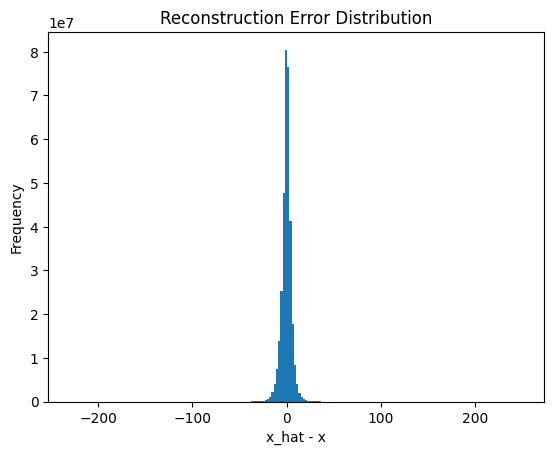

In [2]:
import matplotlib.pyplot as plt

diff = (x_hat_nhw - x_nhw_ori).detach().cpu().numpy().ravel()

plt.figure()
plt.hist(diff, bins=200)
plt.xlabel("x_hat - x")
plt.ylabel("Frequency")
plt.title("Reconstruction Error Distribution")
plt.show()

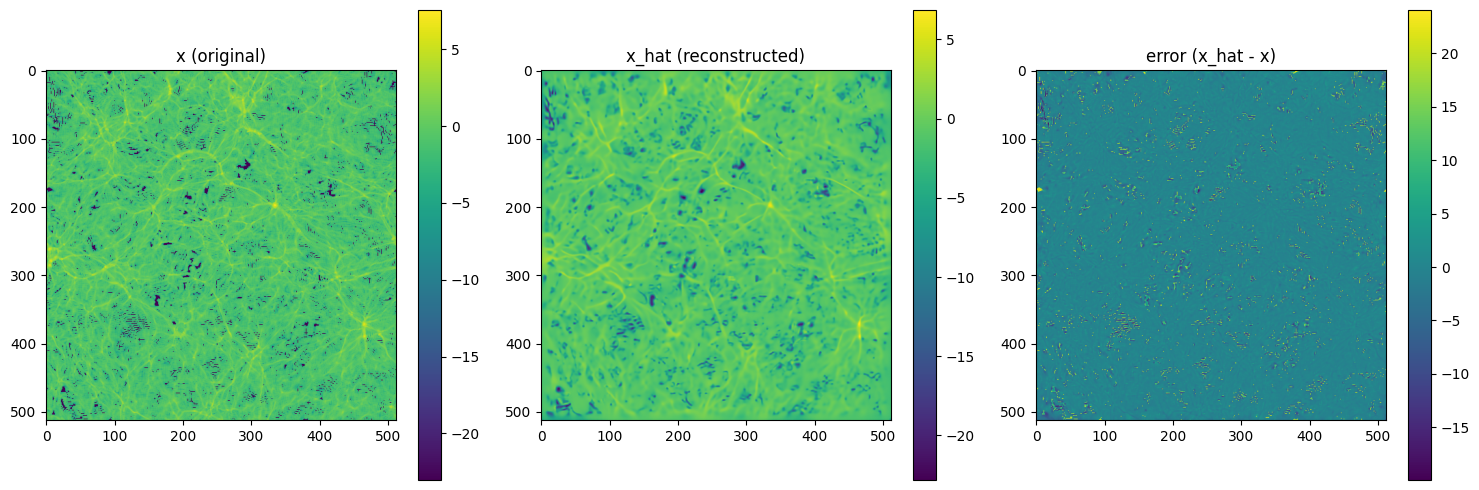

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# err = x_hat_nhw - x_nhw_ori
# abs_err = err.abs().flatten() 

# # 采样数量：你可以调大/调小（1e6 通常很稳）
# num_samples = min(abs_err.numel(), 10000)

# # 90% error 区间阈值：|err| 的 90 分位数
# q = 0.90
# idx = torch.randint(0, abs_err.numel(), (num_samples,), device=abs_err.device)
# sample_data = abs_err[idx]
# T = torch.quantile(sample_data, q)

# # 记录边界 error（阈值）
# print(f"q={q}, abs_err threshold T={T}")
# print("err min/max:", err.min(), err.max())
# print("abs_err min/max:", abs_err.min(), abs_err.max())

# # 找出异常点（超阈值）
# mask_bad = abs_err > T
# print("bad ratio:", mask_bad.float().mean().item())

# mask_bad = mask_bad.reshape(x_nhw_ori.shape)

# # 修正：把异常位置的 x_hat 直接替换成 x
# xh_fix = x_hat_nhw.clone()
# xh_fix[mask_bad] = x_nhw_ori[mask_bad]

# # 修正后的误差
# err_fix = xh_fix - x_nhw_ori
# print("after fix err min/max:", err_fix.min(), err_fix.max())
# metr = metrics.basic_metrics(xh_fix, x_nhw_ori)
# print("rmse:", metr["rmse"])
# print("nrmse:", metr["nrmse"])
# print("maxe:", metr["maxe"])
# print("psnr:", metr["psnr"])

b = 10
x_map = x_nhw_ori[b].detach().cpu().numpy()
xh_map = x_hat_nhw[b].detach().cpu().numpy()
err_map = xh_map - x_map

# 统一 x / x_hat 的颜色范围
vmin = x_map.min()
vmax = x_map.max()

vmin_hat = xh_map.min()
vmax_hat = xh_map.max()

# error 用对称范围（以 0 为中心）
err_abs_max = np.max(np.abs(err_map))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
# plt.imshow(x_map, vmin=vmin, vmax=vmax)
plt.imshow(x_map)
plt.colorbar()
plt.title("x (original)")

plt.subplot(1, 3, 2)
# plt.imshow(xh_map, vmin=vmin_hat, vmax=vmax_hat)
plt.imshow(xh_map)
plt.colorbar()
plt.title("x_hat (reconstructed)")

plt.subplot(1, 3, 3)
plt.imshow(err_map)
plt.colorbar()
plt.title("error (x_hat - x)")

plt.tight_layout()
plt.show()


In [4]:
x_nhw_ori[0,0,:10]

tensor([83., 84., 86., 85., 83., 80., 79., 79., 82., 79.], device='cuda:0')

In [11]:
from compressai.utils import dataloader_science
import numpy as np
import torch

bin_path = "/hwj/data/testData/cesm_77x1x1800x3600.f32"
input_shape = (77, 1800, 3600)            # (N,H,W)
block_size = (3, 512, 512)            # (bn,3,bh,bw)
stride = (256,256)
p=0.5
device = "cuda:0"

# loader, x_nhw_ori, status = dataloader_science.blockify_bin(
#         bin_path,
#         input_shape,
#         block_size,
#         p,
#         dtype=np.float32,
#         pad_value=0.0,
#         norm_type="minmax",
#         device=device,
#     )

blocks, x_ori, status, meta = dataloader_science.blockify_bin_overlap(
    bin_path, input_shape, block_size, p, (256,256),
    dtype=np.float32, pad_value=0.0, norm_type="minmax", device=device
)

# x_hat_nhw = dataloader_science.blocks_to_nhw(
#     loader,
#     input_shape,
#     block_size,
#     p,
#     pad_value=0.0,
#     norm_type="minmax",
#     data_min=status["min"],
#     data_max=status["max"],
#     mean=status["mean"],
#     std=status["std"],
# )

x_hat = dataloader_science.blocks_to_nhw_overlap_center(
    blocks,
    input_shape,
    block_size,
    p,
    stride_hw=stride,
    meta_hw=meta,
    pad_value=0.0,
    norm_type="minmax",
    data_min=status["min"],
    data_max=status["max"],
    mean=status["mean"],
    std=status["std"],
)
print(blocks.shape)
for i, x in enumerate(blocks):
    # x: (bn, 3, bh, bw) because DataLoader batch_size=1
    # x = x.squeeze(0)  # -> (bn,3,bh,bw)
    print(i, x.shape)
    # feed to your CompressAI model...
    # out = model(x)

torch.Size([2548, 3, 512, 512])
0 torch.Size([3, 512, 512])
1 torch.Size([3, 512, 512])
2 torch.Size([3, 512, 512])
3 torch.Size([3, 512, 512])
4 torch.Size([3, 512, 512])
5 torch.Size([3, 512, 512])
6 torch.Size([3, 512, 512])
7 torch.Size([3, 512, 512])
8 torch.Size([3, 512, 512])
9 torch.Size([3, 512, 512])
10 torch.Size([3, 512, 512])
11 torch.Size([3, 512, 512])
12 torch.Size([3, 512, 512])
13 torch.Size([3, 512, 512])
14 torch.Size([3, 512, 512])
15 torch.Size([3, 512, 512])
16 torch.Size([3, 512, 512])
17 torch.Size([3, 512, 512])
18 torch.Size([3, 512, 512])
19 torch.Size([3, 512, 512])
20 torch.Size([3, 512, 512])
21 torch.Size([3, 512, 512])
22 torch.Size([3, 512, 512])
23 torch.Size([3, 512, 512])
24 torch.Size([3, 512, 512])
25 torch.Size([3, 512, 512])
26 torch.Size([3, 512, 512])
27 torch.Size([3, 512, 512])
28 torch.Size([3, 512, 512])
29 torch.Size([3, 512, 512])
30 torch.Size([3, 512, 512])
31 torch.Size([3, 512, 512])
32 torch.Size([3, 512, 512])
33 torch.Size([3, 512

Text(0.5, 1.0, 'x (original)')

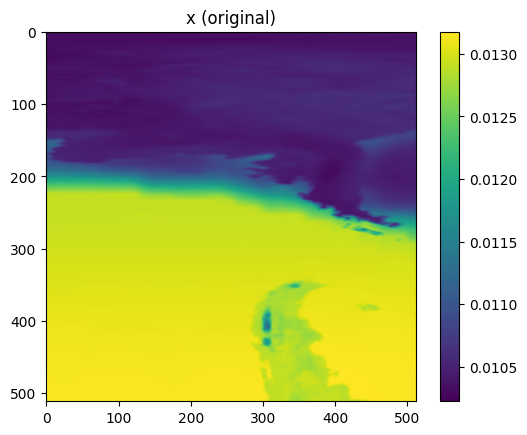

In [6]:
import matplotlib.pyplot as plt
import numpy as np

x_map = blocks[10][0]
plt.imshow(x_map.cpu().numpy())
plt.colorbar()
plt.title("x (original)")

In [8]:
print(torch.allclose(x_hat, x_ori, atol=1e-6, rtol=0))
diff = (x_hat - x_ori).abs()
print(diff.max().item(), diff.mean().item())



False
0.00390625 2.9106196961947717e-05
